## Time series pattern recognition with air quality sensor data
### part 4. Collective anomaly detection

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>

<div style="text-align: right\"> Initial upload: 2020.1.15 </div>
<div style="text-align: right\"> Last update: 2020.1.15</div>

참고자료  
- https://towardsdatascience.com/time-series-pattern-recognition-with-air-quality-sensor-data-4b94710bb290  
- https://github.com/zhouxu-ds/air-quality-pattern-recognition  
- https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a

Collective anomaly를 검출하는 알고리즘을 구현한다.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from tqdm.notebook import tqdm
from sklearn.ensemble import GradientBoostingRegressor

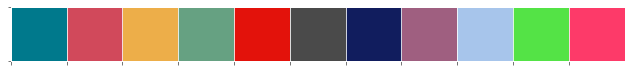

In [3]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#e3120b', '#4a4a4a', 
          '#111D5E', '#9F5F80', '#A7C5EB', '#54E346', '#FD3A69']
sns.palplot(sns.color_palette(colors))

In [4]:
import pickle

### 1. 데이터 읽기

In [5]:
# Load dataframes from pickle file
with open('./data_full.pkl', 'rb') as f:
    data, data_norm = pickle.load(f)

In [6]:
data.head(3)

,Ozone - Low Conc.,Hydrogen Sulfide - Low Conc.,Total VOCs (ppm) - PID,Carbon Dioxide - Low Conc.,Particulate Matter 1,Particulate Matter 2.5,Particulate Matter 10,Temperature (Internal),Humidity (Internal),Temperature (External),Humidity (External)
timestamp,,,,,,,,,,,
2020-05-26 08:51:45,0.210,0.000,0.266,466.607,18.270,19.519,19.759,23.87,45.76,23.25,47.54
2020-05-26 08:52:44,0.217,0.001,0.268,467.189,14.326,15.149,15.149,23.81,45.93,23.18,47.75
2020-05-26 08:53:44,0.222,0.001,0.269,468.038,10.830,11.453,11.453,23.91,45.94,23.25,47.84


In [7]:
print(data.shape)
print(data_norm.shape)

(19744, 11)
(19744, 11)


### 2. 데이터 전처리

이상치제거 : Collective anomaly detection을 수행하기 전 point anomaly를 제거

In [8]:
def is_outlier(data, rolling_median, thresh):
    if not pd.isna(rolling_median):
        return abs(data - rolling_median) >= thresh

In [9]:
data_nrm5 = data_norm.rolling(window=5, center = True).median() 
# center를 True로 하면 윈도우 중간을 기준으로 동작함
data_nc = data_norm.copy()
s = data_nc.shape

In [10]:
for col in range(s[1]):
    for row in range(s[0]):
        if is_outlier(data_nc.iloc[row, col], data_nrm5.iloc[row, col], 0.2):
            data_nc.iloc[row, col] = data_nrm5.iloc[row, col]

### 3. 특징 추출 및 회귀모델 구축

시계열에서 지도학습용 피처를 만들어내는 함수

In [11]:
def ts_to_features(ts, n_features=61):
    X, y = np.zeros([len(ts) - n_features, n_features]), np.zeros([len(ts) - n_features, 1])
    for i in range(len(ts)-n_features):
        X[i, :] = ts[i:i+n_features]
        y[i] = ts[i+n_features]
    return X, y.flatten()

예측함수

In [12]:
def ts_predict(X, y):
    lower_alpha = 0.1
    upper_alpha = 0.9
    predictions = np.ones([1, 4])
    for i in tqdm(range(1, X.shape[0])):
        lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=lower_alpha)
        mid_model = GradientBoostingRegressor(loss="ls")
        upper_model = GradientBoostingRegressor(loss="quantile",
                                                alpha=upper_alpha)
        lower_model.fit(X[:i,:], y[:i])
        mid_model.fit(X[:i,:], y[:i])
        upper_model.fit(X[:i,:], y[:i])
        
        pred = np.hstack([y[i], 
                          lower_model.predict(X[i:i+1, :]),
                          mid_model.predict(X[i:i+1, :]),
                          upper_model.predict(X[i:i+1, :])])
        predictions = np.vstack([predictions, pred])
    return predictions[1:, :]

오존 컬럼만 사용한다.  
**그리고 시간 단위 샘플만 추출한다.**

In [13]:
h = data_nc['Ozone - Low Conc.'].values
h = h[range(0, len(h), 61)]
len(h)

324

In [14]:
X, y = ts_to_features(h, 5)
p = ts_predict(X, y)

In [15]:
X.shape

(319, 5)

In [16]:
y.shape

(319,)

In [17]:
p.shape

(318, 4)

In [18]:
# Create labels for data points based on in/out of the prediction interval
p = pd.DataFrame(p)
p.columns = ['actual', 'lower', 'mid', 'upper']
p['label'] = np.ones(len(p))
for i in range(len(p)):
    if p['actual'].iloc[i] > p['upper'].iloc[i]:
        p['label'].iloc[i] = 2
    if p['actual'].iloc[i] < p['lower'].iloc[i]:
        p['label'].iloc[i] = 0

### 4. 시각화

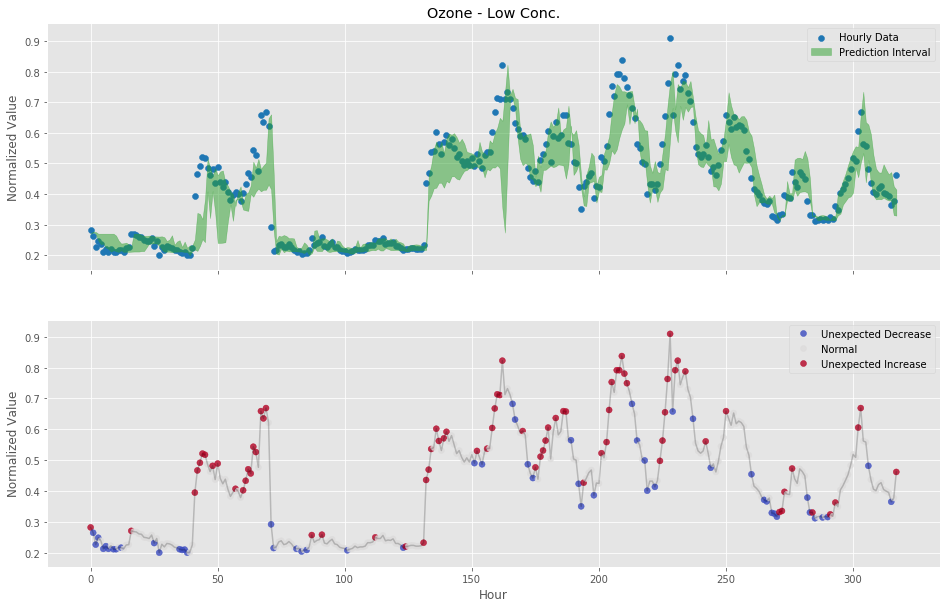

In [19]:
# Plot two scatter plots, showing the prediction interval and labels
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 10))
ax1.scatter(p.index, p['actual'], color='tab:blue', alpha=1, label='Hourly Data')
ax1.fill_between(p.index, p['upper'], p['lower'], color='tab:green', alpha=0.5, label='Prediction Interval')
ax1.set_ylabel('Normalized Value')
ax1.legend()
ax1.set_title('Ozone - Low Conc.')
ax2.plot(p['actual'], color='black', alpha=0.2)
scatter = ax2.scatter(p.index, p['actual'], c=p['label'], cmap=plt.get_cmap('coolwarm'), alpha=0.8)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Normalized Value')
ax2.legend(handles=scatter.legend_elements()[0], labels=['Unexpected Decrease', 'Normal', 'Unexpected Increase'])
plt.show()